In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

# Runtime Comparison

In [5]:
nrays = np.arange(10,110,10)
pth = '/Users/jashcraft/Desktop/poke/experiments/weber/runtimes/'
# load up runtimes
gpu_old = np.load(pth+'runtime_old_gpu_10.npy')
gpu_new = np.load(pth+'runtime_new_gpu_10.npy')
cpu_old = np.load(pth+'runtimes_old_cpu_10.npy')
cpu_new = np.load(pth+'runtimes_new_cpu_10.npy')

cpu_old = np.broadcast_to(cpu_old,gpu_old.shape)
cpu_new = np.broadcast_to(cpu_new,gpu_old.shape)

# load up rms
gpu_old_rms = np.load(pth+'rms_old_gpu_10.npy')
gpu_new_rms = np.load(pth+'rms_new_gpu_10.npy')
cpu_old_rms = np.load(pth+'rms_old_cpu_10.npy')
cpu_new_rms = np.load(pth+'rms_new_cpu_10.npy')

(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)


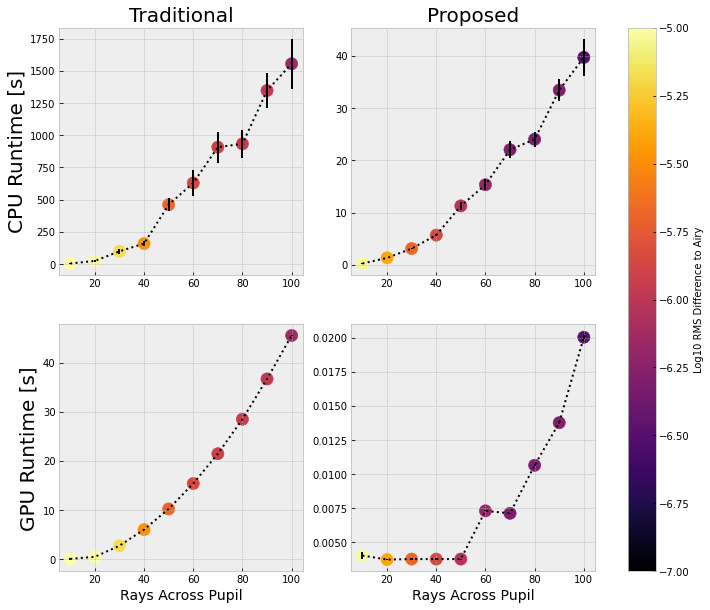

In [6]:
plt.style.use('bmh')
runtimes = [cpu_old,cpu_new,gpu_old,gpu_new]
stddevs = [cpu_old_rms,cpu_new_rms,gpu_old_rms,gpu_new_rms]
for t,s in zip(runtimes,stddevs):
    print(t.shape)
    print(s.shape)
titles = ['Traditional','Proposed','','']
ylabels = ['CPU Runtime [s]','','GPU Runtime [s]','']
xlabels = ['','','Rays Across Pupil','Rays Across Pupil']
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=[12,10])
i = 0
for ax,t,rms,title,ylabel,xlabel in zip(axs.ravel(),runtimes,stddevs,titles,ylabels,xlabels):
    ax.set_title(title,fontsize=20)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(xlabel,fontsize=14)
    im = ax.scatter(nrays,np.mean(t,axis=0),c=np.log10(np.mean(rms,axis=0)),vmin=-7,vmax=-5,s=150,cmap='inferno')
    ax.errorbar(nrays,np.mean(t,axis=0),(np.std(t,axis=0)),color='black',linestyle='dotted')
fig.colorbar(im,ax=axs,label='Log10 RMS Difference to Airy')


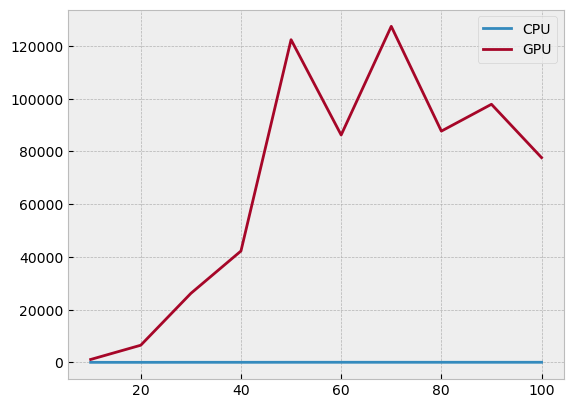

In [658]:
rel_accel_cpu = np.mean(cpu_old,axis=0)/np.mean(cpu_new,axis=0)
rel_accel_gpu = np.mean(cpu_old,axis=0)/np.mean(gpu_new,axis=0)

plt.figure()
plt.plot(nrays,rel_accel_cpu,label='CPU')
plt.plot(nrays,rel_accel_gpu,label='GPU')
# plt.yscale('log')
plt.legend()
plt.show()

In [661]:
%%timeit
np.fft.fft2(mask_0_to_5)

8.19 ms ± 947 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


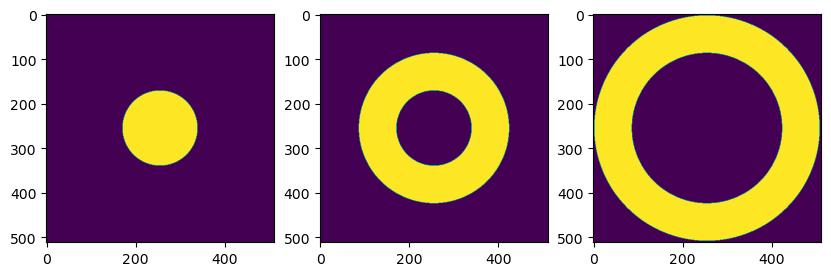

In [555]:
pix_mas = 2.8
pix_rad = pix_mas / 1e3 / 206265
pix_LD = pix_rad * 2.4 / 551e-9

uld = np.linspace(-pix_LD*512/2,pix_LD*512/2,512)
uld,vld = np.meshgrid(uld,uld)
rld = np.sqrt(uld**2 + vld**2)
mask = np.zeros_like(uld)

# generate boolean masks
mask_0_to_5 = np.copy(mask)
mask_5_to_10 = np.copy(mask)
mask_10_to_15 = np.copy(mask)

# 0 - 5 L/D
mask_0_to_5[rld < 5] = 1

# 5 - 10 L/D
mask_5_to_10[rld < 10] = 1
mask_5_to_10[rld < 5] = 0

# 10 - 15 L/D 
mask_10_to_15[rld < 15] = 1
mask_10_to_15[rld < 10] = 0

masks = [mask_0_to_5,mask_5_to_10,mask_10_to_15]
plt.figure(figsize=[10,3])
for i,m in enumerate(masks):
    plt.subplot(1,3,i+1)
    plt.imshow(m)
plt.show()

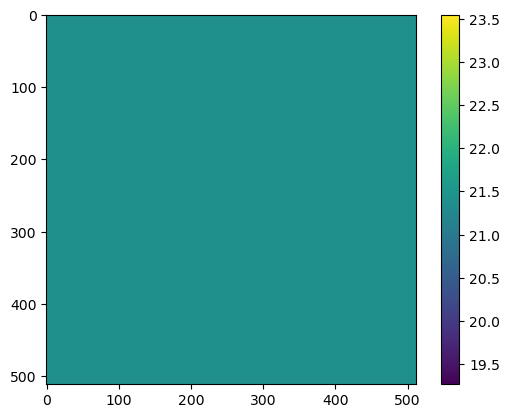

In [556]:
from scipy.signal import correlate2d
fields = np.load('irrad_gbd_512pix_2.8mas_551nm.npy')
airy = np.load('airy_epd_2400mm_wlen_551nm_pixscale_2.8mas_npix_512.npy')
airy /= np.sum(airy)
mtf_airy = np.abs(np.fft.ifftshift(np.fft.ifft2(airy)))
mtf_airy /= np.max(mtf_airy)

In [537]:
fractional_difference = (fields - airy)/airy
print(fractional_difference.shape)

(11, 10, 512, 512)


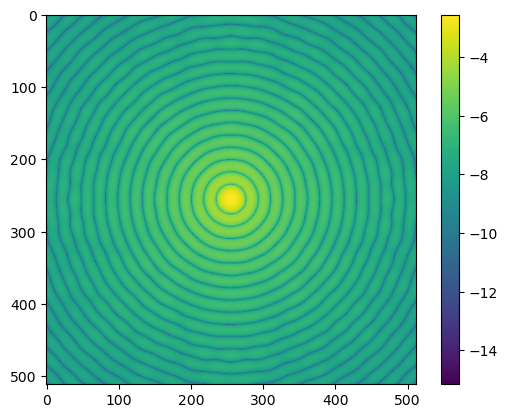

In [541]:
fields.shape
plt.imshow(np.log10(field))
plt.colorbar()

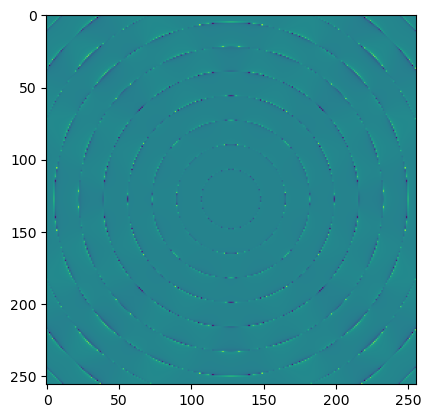

In [427]:
difference_metric = np.zeros([11,10])
mtfs = np.empty_like(fields)

In [378]:
for i in range(11):
    for j in range(10):
        field = fields[i,j]
        field /= np.sum(field)
        mult = field * field
        mtfs[i,j] = np.abs(np.fft.ifftshift(np.fft.ifft2(mult)))

In [646]:

def gaussian_weighted_std(psf,airy):
    psf /= np.sum(psf)
    waist = 2
    x = np.linspace(-1,1,psf.shape[0])
    x,y = np.meshgrid(x,x)
    r = np.sqrt(x**2 + y**2)
    gauss = np.exp(-(r/waist)**2)

    difference = psf - airy
    mask = np.ones_like(difference)
    mask -= gauss

    return np.std(difference*mask)
    

def strehl(psf,airy):
    return np.max(psf)/np.max(airy)

def ssim(psf,airy):

    pixscal = 200e-6/256
    varx = np.var(psf)
    vary = np.var(airy)
    k1 = 0.01
    k2 = 0.03
    L = (2**64 - 1)
    c1 = (k1*L)**2
    c2 = (k2*L)**2

    numerator = (2*pixscal**2 + c1) * (c2)
    denomenator = (2*pixscal**2 + c1) * (varx + vary + c2)

    return numerator/denomenator

def fractional_difference(psf,airy):

    # set up mask
    mask = np.copy(psf)
    threshold = 1e-7
    mask[mask < threshold] = 0
    mask[mask >= threshold] = 1    

    difference = (psf - airy) / airy
    
    return np.std(difference[mask==1])

difference_metric_0_5 = np.copy(difference_metric)
difference_metric_5_10 = np.copy(difference_metric)
difference_metric_10_15 = np.copy(difference_metric)

for i in range(11):
    for j in range(10):
        field = fields[i,j]
        field /= np.sum(field)
        # logfield = np.log10(field)
        # logairy = np.log10(airy)
        difference_metric[i,j] = np.std(field-airy)
        difference_metric_0_5[i,j] = np.std((field-airy)[mask_0_to_5==1])
        difference_metric_5_10[i,j] = np.std((field-airy)[mask_5_to_10==1])
        difference_metric_10_15[i,j] = np.std((field-airy)[mask_10_to_15==1])

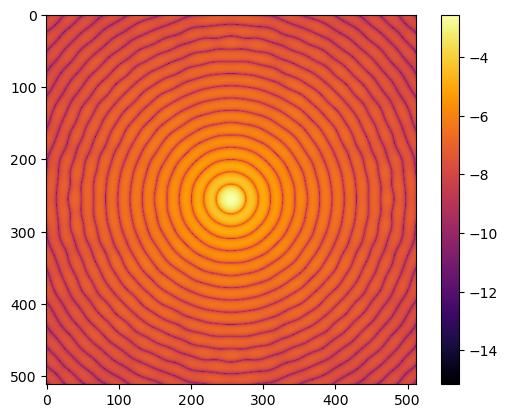

In [535]:
fracdif = fractional_difference(field,airy)
# plt.imshow(fractional_difference(field,airy),vmin=-1,vmax=1)
# plt.colorbar()
mask = np.copy(field)
threshold = 1e-7
mask[mask < threshold] = 0
mask[mask >= threshold] = 1
plt.figure()
plt.imshow(np.log10(field),cmap='inferno')
plt.colorbar()
plt.show()

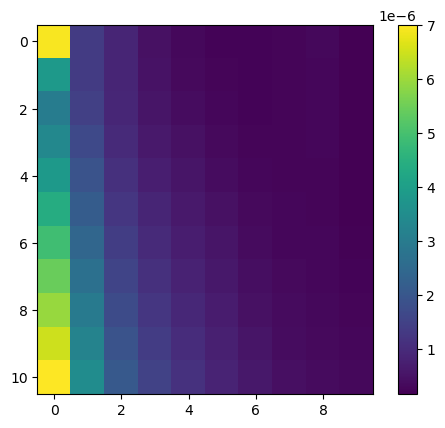

In [649]:
plt.imshow(difference_metric)
plt.colorbar()

<ipython-input-412-081497c95b8e>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(mtf_airy/np.max(mtf_airy)),vmin=-5)


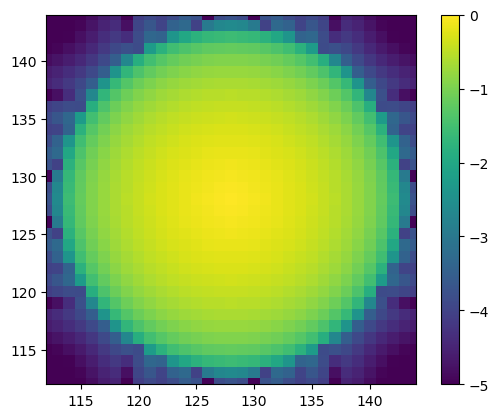

In [412]:
i,j = -1,-1
center = 128
cropto = 16
mtf = mtfs[i,j]
plt.figure()
plt.imshow(np.log10(mtf_airy/np.max(mtf_airy)),vmin=-5)
plt.colorbar()
plt.xlim([128-cropto,128+cropto])
plt.ylim([128-cropto,128+cropto])
plt.show()

u = np.linspace(-1,1,int(cropto*2))
u,v = np.meshgrid(u,u)
annulus_in = np.zeros_like(u)
annulus_out = np.zeros_like(u)
r = np.sqrt(u**2 + v**2)
annulus_in[r < 0.5] = 1
annulus_out[r >= 0.5] = 1
annulus_out[r > 0.9] = 0

rms_inner = np.zeros([11,10])
rms_outer = np.copy(rms_inner)
# compute rms difference mtf at different annuluses
for i in range(11):
    for j in range(10):
        difference = (mtfs[i,j]/np.max(mtfs[i,j]) - mtf_airy)#/mtf_airy
        crop_difference = difference[center-cropto:center+cropto,center-cropto:center+cropto]
        rms_inner[i,j] = np.std(crop_difference[annulus_in == 1])
        rms_outer[i,j] = np.std(crop_difference[annulus_out == 1])

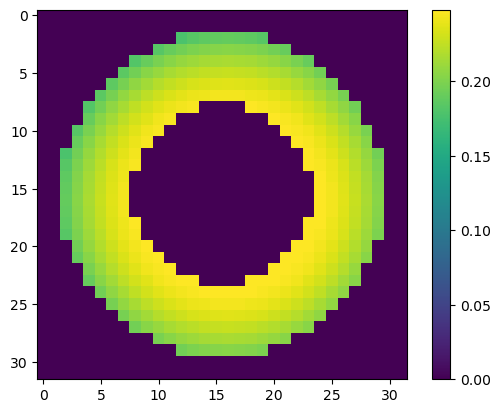

In [413]:
plt.imshow(difference[center-cropto:center+cropto,center-cropto:center+cropto]*annulus_out)
plt.colorbar()

<ipython-input-645-1440a2d88395>:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


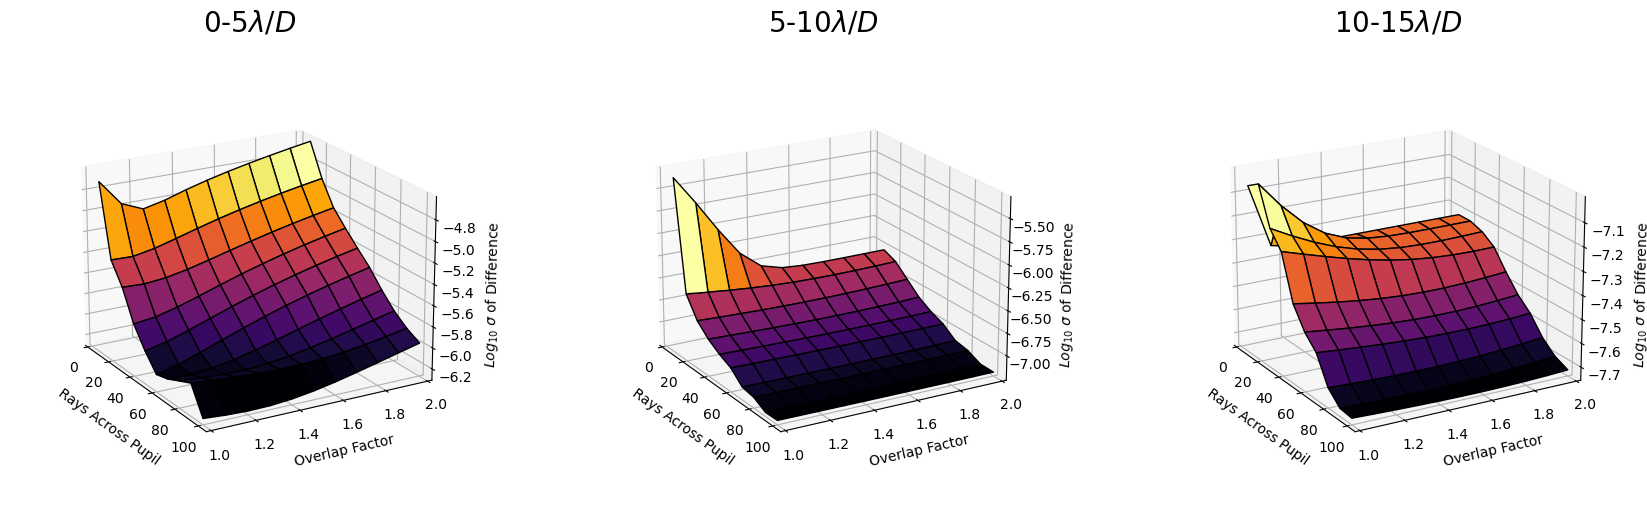

In [645]:
data = [difference_metric_0_5,difference_metric_5_10,difference_metric_10_15]
titles = ['0-5','5-10','10-15']

plt.style.use('default')
y = np.arange(1,2.1,.1)
x = np.arange(10,110,10)
xx,yy = np.meshgrid(x,y)
v = np.arange(0.8,2.2,.2)
u = np.arange(0,120,20)
fig,axs = plt.subplots(ncols=3,subplot_kw={'projection':'3d'},figsize=[21,10])
for d,ax,tit in zip(data,axs,titles):
    im = ax.plot_surface(xx,yy,np.log10(d),cmap='inferno',rstride=1, cstride=1, edgecolor='black')
    # ax.set_title('0 - 5'+r'$\lambda / D$')
    ax.set_xticks(u)
    ax.set_yticks(v)
    ax.set_xlabel('\n Rays Across Pupil')
    ax.set_ylabel('\n Overlap Factor')
    ax.set_zlabel('\n'+r'$Log_{10}$'+' '+r'$\sigma$'+' of Difference')
    ax.view_init(20,-30)
    ax.set_ylim([1,2])
    ax.dist = 12
    ax.set_title(tit+r'$\lambda/D$',fontsize=20)
# fig.colorbar(im)
plt.subplots_adjust()
plt.show()

<ipython-input-654-feb72f9ab237>:17: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


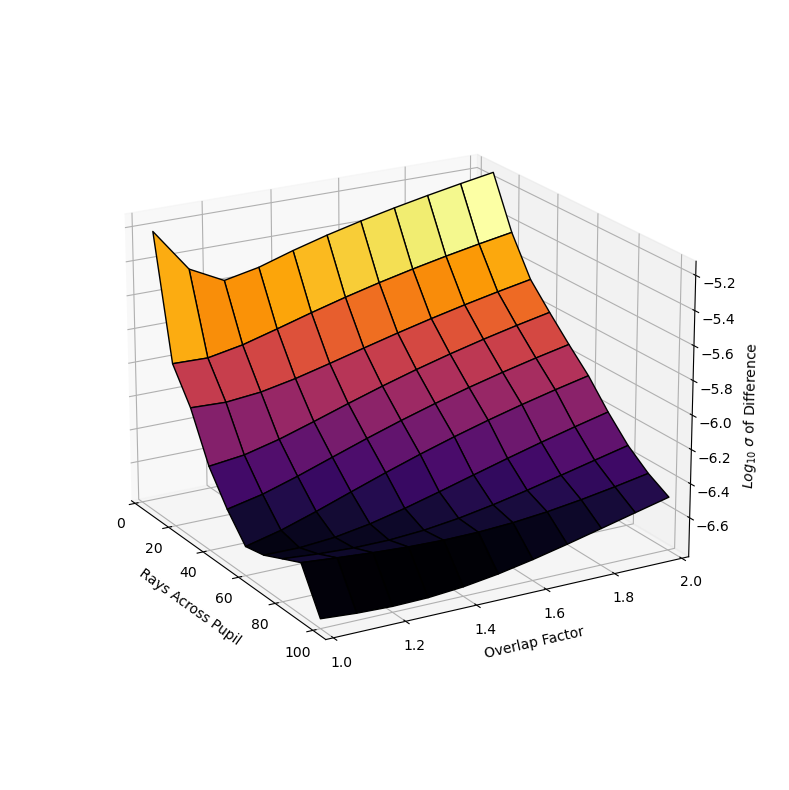

In [654]:
plt.style.use('default')
y = np.arange(1,2.1,.1)
x = np.arange(10,110,10)
xx,yy = np.meshgrid(x,y)
v = np.arange(0.8,2.2,.2)
u = np.arange(0,120,20)
fig,ax = plt.subplots(subplot_kw={'projection':'3d'},figsize=[21,10])
im = ax.plot_surface(xx,yy,np.log10(difference_metric),cmap='inferno',rstride=1, cstride=1, edgecolor='black')
# ax.set_title('0 - 5'+r'$\lambda / D$')
ax.set_xticks(u)
ax.set_yticks(v)
ax.set_xlabel('\n Rays Across Pupil')
ax.set_ylabel('\n Overlap Factor')
ax.set_zlabel('\n'+r'$Log_{10}$'+' '+r'$\sigma$'+' of Difference')
ax.view_init(20,-30)
ax.set_ylim([1,2])
ax.dist = 12
# fig.colorbar(im)
# plt.subplots_adjust()
plt.show()

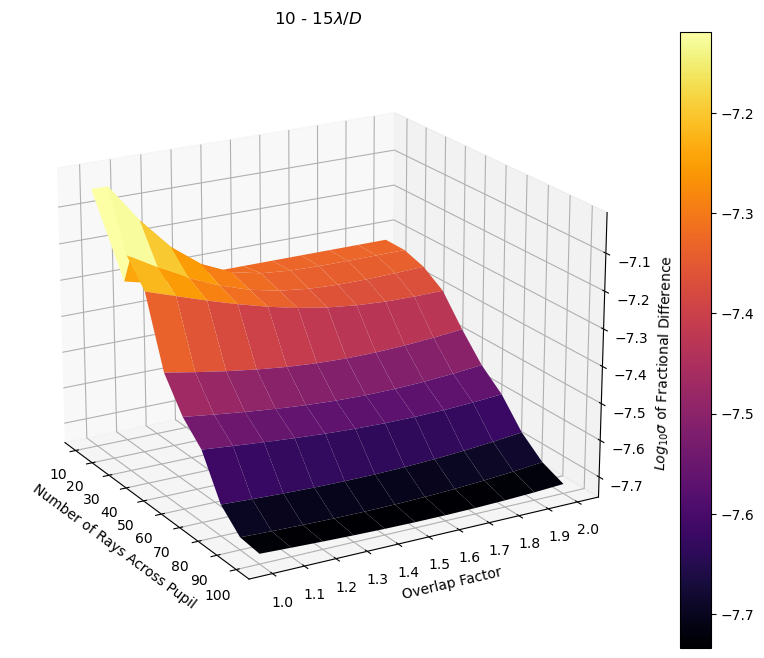

In [575]:
plt.style.use('default')
y = np.arange(1,2.1,.1)
x = np.arange(10,110,10)
xx,yy = np.meshgrid(x,y)
fig,ax = plt.subplots(subplot_kw={'projection':'3d'},figsize=[14,8])
im = ax.plot_surface(xx,yy,np.log10(difference_metric_10_15),cmap='inferno',rstride=1, cstride=1)
plt.title('10 - 15'+r'$\lambda / D$')
plt.xticks(x)
plt.yticks(y)
ax.set_xlabel('Number of Rays Across Pupil')
ax.set_ylabel('Overlap Factor')
ax.set_zlabel(r'$Log_{10}\sigma$'+' of Fractional Difference')
ax.view_init(20,-30)
fig.colorbar(im)
plt.show()

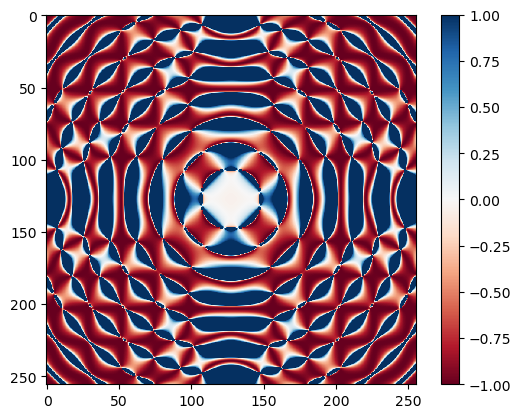

In [150]:
plt.imshow(fractional_difference[-0,-0],cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar()

In [235]:
import numpy as np
import matplotlib.pyplot as plt

npix = 20

x = np.linspace(-1,1,npix)
fx = lambda a: (-a**4 + a**2)
# fx = lambda a: np.ones_like(a)
dx = lambda a: 4*a**3 - 2*a
u = np.linspace(-1,1,npix)
up = np.copy(u) + u[1] - u[0]
th = np.arctan2(fx(up)-fx(u),up-u) + np.pi/2

# create a small gaussian
tol = 5e-2
width = tol*0.5
f = np.linspace(-tol,tol,40)
gauss = lambda a: np.exp(-(a/width)**2)
ngauss = len(u)

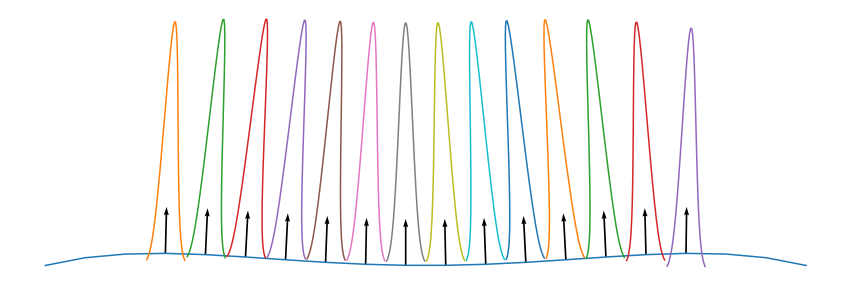

In [230]:

plt.figure(figsize=[15,5])
plt.plot(x,fx(x))
plt.quiver(u[3:-3],fx(u)[3:-3],np.cos(th)[3:-3],np.sin(th)[3:-3],width=2e-3)
for i in range(ngauss):
    if (i > 2) and (i < ngauss-3):
        pos_vec = np.array([f-u[i],gauss(f)+fx(u)[i]/2])
        rotmat = np.array([[np.cos(th[i]),np.sin(th[i])],[-np.sin(th[i]),np.cos(th[i])]])
        rot_vec = rotmat @ pos_vec
        rotated_y = rot_vec[0]
        rotated_x = rot_vec[1]
        plt.plot(rotated_x,(rotated_y-fx(u)[i])/2)
# plt.ylim([-1,1])
plt.axis('off')
plt.show()

In [157]:
help(plt.quiver)

Help on function quiver in module matplotlib.pyplot:

quiver(*args, data=None, **kwargs)
    Plot a 2D field of arrows.
    
    Call signature::
    
      quiver([X, Y], U, V, [C], **kwargs)
    
    *X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
    *C* optionally sets the color.
    
    **Arrow length**
    
    The default settings auto-scales the length of the arrows to a reasonable size.
    To change this behavior see the *scale* and *scale_units* parameters.
    
    **Arrow shape**
    
    The arrow shape is determined by *width*, *headwidth*, *headlength* and
    *headaxislength*. See the notes below.
    
    **Arrow styling**
    
    Each arrow is internally represented by a filled polygon with a default edge
    linewidth of 0. As a result, an arrow is rather a filled area, not a line with
    a head, and `.PolyCollection` properties like *linewidth*, *edgecolor*,
    *facecolor*, etc. act accordingly.
    
    
    Parameters
    ------

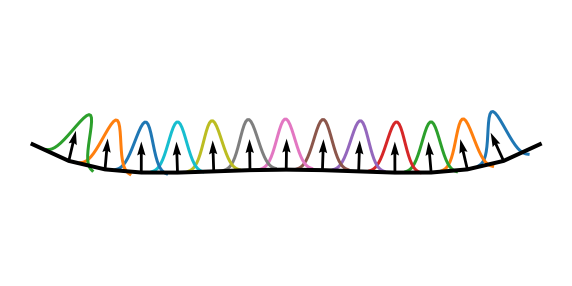

In [339]:
npix = 15
u = np.linspace(-1,1,npix)
up = np.copy(u) + u[1] - u[0]

gauss = lambda a: np.exp(-(a/0.05)**2)/5
fx = lambda a: (0.2*a**4 - 0.1*a**2)
# fx = lambda a: np.zeros_like(a)
gx = np.linspace(-0.1,0.1,30)

dx = up - u
dy = fx(up)-fx(u)
norm = np.sqrt(dx**2 + dy**2)
dx /= norm
dy /= norm
rot90mat = np.array([[0,-1],[1,0]])
posvec = np.array([dx,dy])
rotvec = rot90mat @ posvec
plt.figure(figsize=[10,5])
plt.quiver(u[1:-1],fx(u)[1:-1],rotvec[0][1:-1],rotvec[1][1:-1],width=5e-3)
for i,(xl,yl,l,m) in enumerate(zip(u,fx(u),rotvec[0],rotvec[1])):
    if (i > 0) and (i < len(u)-1):
        gy = gauss(gx)
        theta = -np.arctan(l/m)

        # rotation matrix
        rot = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
        pos = np.array([gx,gy])
        posrot = rot @ pos

        # plt.plot(gx-xl,gy+yl)
        plt.plot(posrot[0]-xl,posrot[1]+yl,linewidth=3)
plt.plot(u,fx(u),linewidth=4,color='black')
plt.axis('equal')
plt.axis('off')
plt.show()

In [1]:
import numpy as np
x = np.linspace(-1,1,256)
x,y = np.meshgrid(x,x)
mask = np.zeros_like(x)
mask[x**2 + y**2 < 1] = 1

In [2]:
%%timeit
np.fft.fftshift(np.fft.fft2(mask))

1.22 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
